# 2D Coordinate systems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
import sympy as sp
from sympy.abc import theta, gamma
from sympy.vector import CoordSys3D

In [3]:
import math as math

In [4]:
upper_leg_length = 3
lower_leg_length = 4

## Define a coordiate system as origin of the upper leg

In [5]:
U = CoordSys3D('U')

## Upper leg

The upper leg is connected to the origin of this coordinate system and rotated by an angle of theta. Calculate the location of the end of the upper leg

In [6]:
lu = upper_leg_length*sp.cos(theta)*U.i + upper_leg_length*sp.sin(theta)*U.j
print(lu)

(3*cos(theta))*U.i + (3*sin(theta))*U.j


## Draw reach of upper leg

We assume that neutral is -135 degree and the servo can move +/- 90 degree

In [7]:
from sympy.plotting import plot_parametric

In [8]:
deg135 = 3*sp.pi.evalf()/4
deg90 = sp.pi.evalf()/2

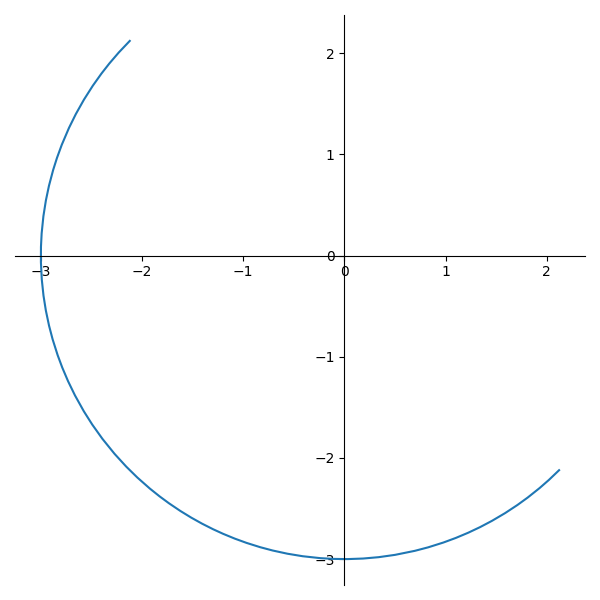

In [9]:
plot_parametric((upper_leg_length*sp.cos(theta), upper_leg_length*sp.sin(theta)), (theta, -deg90-deg135, deg90-deg135), size=(6.0, 6.0))

## Coordinate systen for the upper leg
Attach a new coordinate system to the end of the upper leg and the x-axis having the same direction of the upper leg

In [10]:
L = U.orient_new_axis('L', theta, U.k, location=lu)

## Location of the foot

Calculate the location of the end of the lower leg in this coordinate system

In [11]:
ll =lower_leg_length*sp.cos(gamma)*L.i + lower_leg_length*sp.sin(gamma)*L.j
print(ll)

(4*cos(gamma))*L.i + (4*sin(gamma))*L.j


## Make some drawings

In [12]:
t = np.radians(-135)
g = np.radians(80)
lu_example = lu.evalf(subs={theta: t})
ll_example = ll.evalf(subs={gamma: g})

In [13]:
# lower leg coordinate system seen in upper leg coordinate system
Lx = sp.vector.express(L.i, U)
Ly = sp.vector.express(L.j, U)
Lx_example = Lx.evalf(subs={theta: t})
Ly_example = Ly.evalf(subs={theta: t})

Text(0.5, 1.0, 'Minipupper Leg')

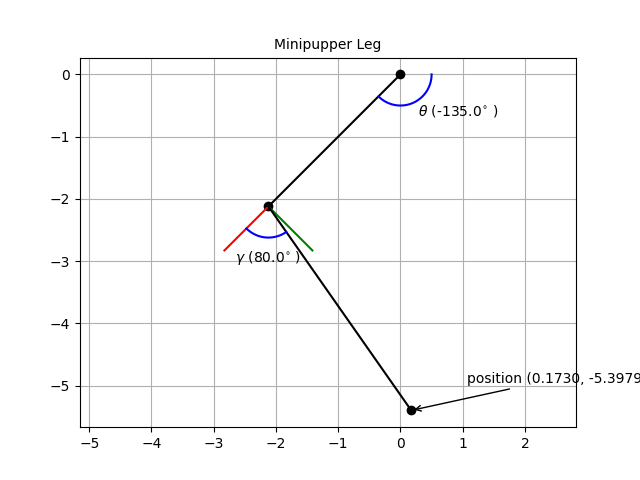

In [14]:
points = np.zeros((2, 2))
points[0,1] = float(lu_example.components.get(U.i, 0))
points[1,1] = float(lu_example.components.get(U.j, 0))

fig, ax = plt.subplots()
plt.xlim(-4,4) #<-- set the x axis limits
plt.ylim(-4,4) #<-- set the y axis limits
# plot a black point at the origin
plt.plot(0,0,'ok')
# plot upper leg
plt.plot(points[0], points[1],'-k')
# plot angle
angles = np.linspace(0, float(t))
xs = 0.5 * np.cos(angles)
ys = 0.5 * np.sin(angles)
plt.plot(xs, ys, '-b')
plt.text(xs[int(len(angles)/2)]+0.1, ys[int(len(angles)/2)]-0.2, "$\\theta$ (%s$^{\circ}$ )" % math.degrees(t))
# plot a black point at the joint between upper and lower leg
plt.plot(points[0,1],points[1,1],'ok')
# show coordinate system for lower leg
points[:,0] = points[:,1]
points[0,1] = float((lu_example+Lx_example).components.get(U.i, 0))
points[1,1] = float((lu_example+Lx_example).components.get(U.j, 0))
plt.plot(points[0], points[1],'-r')
points[0,1] = float((lu_example+Ly_example).components.get(U.i, 0))
points[1,1] = float((lu_example+Ly_example).components.get(U.j, 0))
plt.plot(points[0], points[1],'-g')
# plot lower leg
points[0,1] = float((lu_example+sp.vector.express(ll_example, U).evalf(subs={theta: t})).components.get(U.i, 0))
points[1,1] = float((lu_example+sp.vector.express(ll_example, U).evalf(subs={theta: t})).components.get(U.j, 0))
plt.plot(points[0], points[1],'-k')
# plot angle
angles = np.linspace(float(t), float(t)+float(g))
xs = points[0,0] + 0.5 * np.cos(angles)
ys = points[1,0] + 0.5 * np.sin(angles)
plt.plot(xs, ys, '-b')
plt.text(xs[int(len(angles)/2)]-0.5, ys[int(len(angles)/2)]-0.4, "$\gamma$ (%s$^{\circ}$ )" % math.degrees(g))
# plot a black point at the end of the lower leg
plt.plot(points[0,1],points[1,1],'ok')
ax.annotate(
    "position (%.4f, %.4f)" % (points[0,1],points[1,1]),
    xy=(points[0,1],points[1,1]), xycoords='data',
    xytext=(40, 20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))



plt.axis('equal')  #<-- set the axes to the same scale

plt.grid(visible=True, which='major')
plt.title('Minipupper Leg',fontsize=10)

## Inverse Kinematics

Given a point in the base coordinate system calculate theta and gamma so that the end point of the lower leg is positioned at that point

There are points with multiple solutions and there are points that can not be reached. Calculate the region that is reachable

In [15]:
P = lu + sp.vector.express(ll, U)
print(P)

(-4*sin(gamma)*sin(theta) + 4*cos(gamma)*cos(theta) + 3*cos(theta))*U.i + (4*sin(gamma)*cos(theta) + 4*sin(theta)*cos(gamma) + 3*sin(theta))*U.j


## Brute force solution
We can derive a system of two nonlinear equations and use a solver to find the solutions. This is quite computational intense and you have to uncomment the line to run it

In [16]:
P1 = P.components[U.i]
P2 = P.components[U.j]
print(P1)
print(P2)

-4*sin(gamma)*sin(theta) + 4*cos(gamma)*cos(theta) + 3*cos(theta)
4*sin(gamma)*cos(theta) + 4*sin(theta)*cos(gamma) + 3*sin(theta)


In [17]:
solution = []
#solution = sp.solvers.solve((P1-points[0,1], P2-points[1,1]), (theta, gamma))

In [18]:
for i in range(len(solution)):
    print("theta: %s, gamma: %s" % (math.degrees(solution[i][0]), math.degrees(solution[i][1])))

## Geometric solution

We will use trigonometric functions to solve the inverse kinematic problem

We introduce a virtual leg lv that spans from the origin of our coordinate system to the point P with coordinates (x, y).

For simplicity we denote in the following calculations l<sub>u</sub>, l<sub>l</sub>, l<sub>v</sub> as the length of the vectors lu, ll, lv. 

We will use the <a href="https://en.wikipedia.org/wiki/Law_of_cosines" target="_blank">law of cosines</a>

The length of the virtual leg is

$$ l_v = \sqrt{x^2 + y^2} $$

and the law of cosines provieds

$$ l_v^2 = l_u^2 + l_l^2 - 2l_u l_l\cos (180-\gamma) $$

With $\cos (180-\gamma) = - \cos (\gamma)$ and the above given length of l<sub>v</sub> we obtain

$$ \cos (\gamma) = \frac{x^2+y^2-l_u^2-l_l^2}{2l_ul_l} $$

Thus

$$ \gamma = \arccos (\frac{x^2+y^2-l_u^2-l_l^2}{2l_ul_l}) $$

Further we know that

$$ x = l_u\cos(\theta) + l_l\cos(\theta+\gamma) $$
$$ y = l_u\sin(\theta) + l_l\sin(\theta+\gamma) $$

With $\cos(a + b) = \cos(a)\cos(b) - \sin(a)\sin(b)$ and $\sin(a+b) = \cos(a)\sin(b)+\cos(b)\sin(a)$ we obtain

$$ x = l_u\cos(\theta) + l_l\cos(\theta)\cos(\gamma)-l_l\sin(\theta)\sin(\gamma) $$
$$ y = l_u\sin(\theta) + l_l\cos(\theta)\sin(\gamma)+l_l\cos(\gamma)\sin(\theta) $$

We now have a system of two linear equations with two variables $\sin(\theta)$ and $\cos(\theta)$

$$ \begin{bmatrix}
x\\
y
\end{bmatrix}
=
\begin{bmatrix}
l_u + l_l\cos(\gamma) & -l_l\sin(\gamma)\\
l_l\sin(\gamma) & l_u+l_l\cos(\gamma)
\end{bmatrix}
=
\begin{bmatrix}
C\\
S
\end{bmatrix} $$

where $C=\cos(\theta)$ and $S=\sin(\theta)$. Knowing that

$$ \tan(\theta) = \frac{\sin(\theta)}{\cos(\theta)} $$

We calculate

$$ \theta = \arctan(\frac{S}{C}) $$

### References
The following sources helped me to refine my understanding

<a href="https://www.cs.cmu.edu/~16311/current/schedule/2022_slides/Inverse_Kinematics_2022_GoodIKIncremental.pdf" target="_blank">Lecture from Howie Choset, Carnegie Mellon</a>

<a href="https://arxiv.org/pdf/1901.00697" target="_blank">Paper from Dhaivat Dholakiya et all</a>



Text(0.5, 1.0, 'Minipupper Leg')

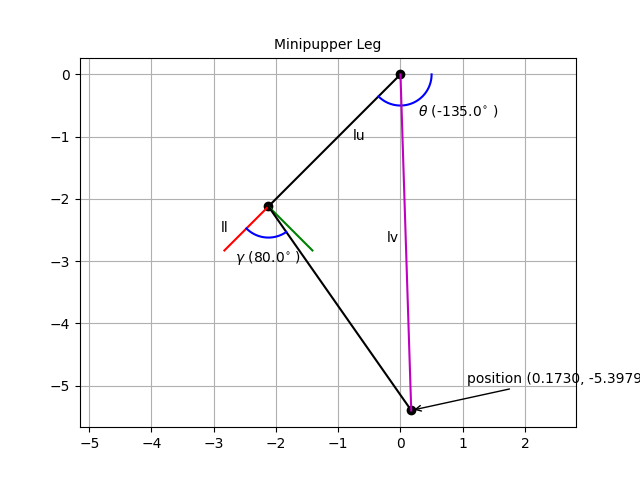

In [19]:
points = np.zeros((2, 2))
points[0,1] = float(lu_example.components.get(U.i, 0))
points[1,1] = float(lu_example.components.get(U.j, 0))

fig, ax = plt.subplots()
plt.xlim(-4,4) #<-- set the x axis limits
plt.ylim(-4,4) #<-- set the y axis limits
# plot a black point at the origin
plt.plot(0,0,'ok')
# plot upper leg
plt.plot(points[0], points[1],'-k')
plt.text(points[0,1]/2+0.3, points[1,1]/2, 'lu')
# plot angle
angles = np.linspace(0, float(t))
xs = 0.5 * np.cos(angles)
ys = 0.5 * np.sin(angles)
plt.plot(xs, ys, '-b')
plt.text(xs[int(len(angles)/2)]+0.1, ys[int(len(angles)/2)]-0.2, "$\\theta$ (%s$^{\circ}$ )" % math.degrees(t))
# plot a black point at the joint between upper and lower leg
plt.plot(points[0,1],points[1,1],'ok')
# show coordinate system for lower leg
points[:,0] = points[:,1]
points[0,1] = float((lu_example+Lx_example).components.get(U.i, 0))
points[1,1] = float((lu_example+Lx_example).components.get(U.j, 0))
plt.plot(points[0], points[1],'-r')
points[0,1] = float((lu_example+Ly_example).components.get(U.i, 0))
points[1,1] = float((lu_example+Ly_example).components.get(U.j, 0))
plt.plot(points[0], points[1],'-g')
# plot lower leg
points[0,1] = float((lu_example+sp.vector.express(ll_example, U).evalf(subs={theta: t})).components.get(U.i, 0))
points[1,1] = float((lu_example+sp.vector.express(ll_example, U).evalf(subs={theta: t})).components.get(U.j, 0))
plt.plot(points[0], points[1],'-k')
plt.text(points[0,0]+points[1,0]/2+0.3, points[0,1]+points[1,1]/2, 'll')
# plot angle
angles = np.linspace(float(t), float(t)+float(g))
xs = points[0,0] + 0.5 * np.cos(angles)
ys = points[1,0] + 0.5 * np.sin(angles)
plt.plot(xs, ys, '-b')
plt.text(xs[int(len(angles)/2)]-0.5, ys[int(len(angles)/2)]-0.4, "$\gamma$ (%s$^{\circ}$ )" % math.degrees(g))
# plot a black point at the end of the lower leg
plt.plot(points[0,1],points[1,1],'ok')
ax.annotate(
    "position (%.4f, %.4f)" % (points[0,1],points[1,1]),
    xy=(points[0,1],points[1,1]), xycoords='data',
    xytext=(40, 20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

# plot a vector from the origin to the foot
new_points = np.zeros((2, 2))
new_points[0,1] = points[0,1]
new_points[1,1] = points[1,1]
plt.plot(new_points[0], new_points[1],'-m')
plt.text(new_points[0,1]/2-0.3, new_points[1,1]/2, 'lv')


plt.axis('equal')  #<-- set the axes to the same scale

plt.grid(visible=True, which='major')
plt.title('Minipupper Leg',fontsize=10)

## Calculate $\gamma$

$$ \gamma = \arccos (\frac{x^2+y^2-l_u^2-l_l^2}{2l_ul_l}) $$

In [20]:
gam = np.arccos((points[0,1]**2+points[1,1]**2-upper_leg_length**2-lower_leg_length**2)/(2*upper_leg_length*lower_leg_length))
print(math.degrees(gam))

80.00000000000001


## Calculate $\theta$

Solving

$$ \begin{bmatrix}
x\\
y
\end{bmatrix}
=
\begin{bmatrix}
l_u + l_l\cos(\gamma) & -l_l\sin(\gamma)\\
l_l\sin(\gamma) & l_u+l_l\cos(\gamma)
\end{bmatrix}
=
\begin{bmatrix}
C\\
S
\end{bmatrix} $$

or

$$ B = \begin{bmatrix}
x\\
y
\end{bmatrix} $$

$$ X = \begin{bmatrix}
X_1\\
X_2
\end{bmatrix}
=\begin{bmatrix}
C\\
S
\end{bmatrix} $$

$$ B = AX $$
$$ X = A^{-1}B $$

and calculating $\theta$


$$ \theta = \arctan(\frac{X_2}{X_1}) $$



In [21]:
B = np.array([points[0,1],points[1,1]])
A11 = upper_leg_length + lower_leg_length * np.cos(gam)
A12 = -lower_leg_length * np.sin(gam)
A21 = lower_leg_length * np.sin(gam)
A22 = upper_leg_length + lower_leg_length * np.cos(gam)

A = np.array([[A11, A12], [A21, A22]])

In [22]:
X = np.linalg.inv(A).dot(B)

In [23]:
thet = np.arctan(X[1]/X[0])
print(math.degrees(thet))
print("%s in the 3rd Quadrant corresponds to %s in the first Quadrant" % (math.degrees(np.pi -thet), math.degrees(thet)))

44.999999999999986
135.0 in the 3rd Quadrant corresponds to 44.999999999999986 in the first Quadrant


## Draw reach of leg

We plot a wide range of servo angles without concern if a physical robot will allow these positions. We observe that some positions cause the end of the upper leg touching the ground and the foot of the leg sticks into the air. If we think about gravity we can see that some positions will put a lot of lateral stress on parts of the leg

In [24]:
def draw_leg(ax, l1, l2, t, g):
    points = np.zeros((2, 3))
    points[0,1] = l1*np.cos(t)
    points[1,1] = l1*np.sin(t)
    points[0,2] = l2*np.cos(g+t) + points[0,1]
    points[1,2] = l2*np.sin(g+t) + points[1,1]
    ax.set_aspect('equal')
    ax.set(xlim=(-5, 5), ylim=(-5, 5))
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.plot(points[0],points[1])

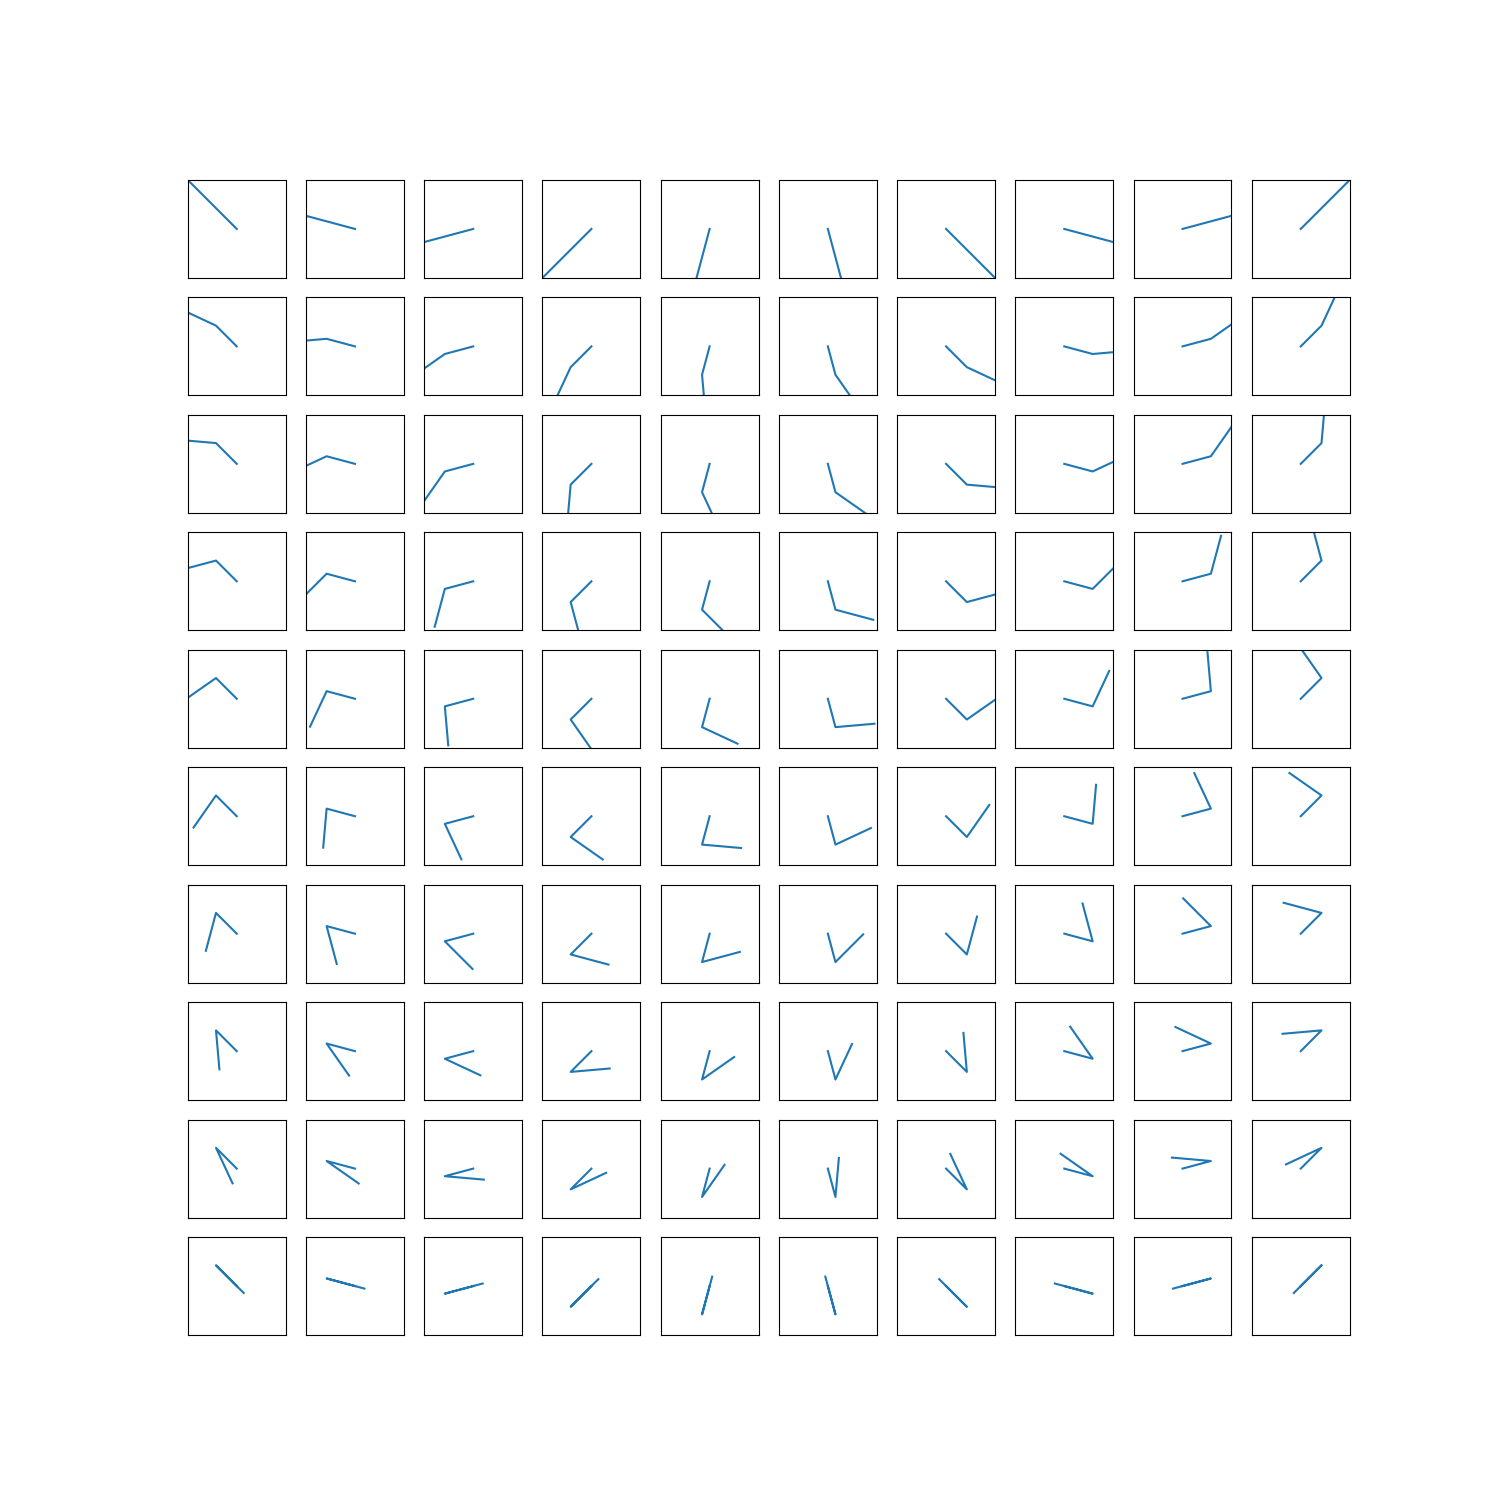

In [25]:
ncols=10
nrows=10
l1_angles = np.linspace(-5*np.pi/4, np.pi/4, num=ncols)
l2_angles = np.linspace(0.0, np.pi, num=nrows)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols):
        draw_leg(axs[row, col], upper_leg_length, lower_leg_length, l1_angles[col], l2_angles[row])

In [26]:
col=5
row=4
print("%s %s" % (np.degrees(l1_angles[col-1]), np.degrees(l2_angles[row-1])))

-105.00000000000001 59.99999999999999
